<a href="https://colab.research.google.com/github/darttusin/DriveNext/blob/master/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация (base)**

### **Оценивание и штрафы**

С наступающим новым годом, друзья! Магистратура бежит быстро и мы бежим очень быстро, а зима — то время, когда хотелось бы бежать чуть медленнее. Поэтому это домашнее задание мы сделали сильно короче от его начальной версии!

Как всегда, каждая из задач имеет «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

В задании две части:

- Часть 1: написание логистической регрессии своими руками — уверенны, логлосс вы уже знаете как свои пять пальцев.
- Часть 2: решение задачи классификации на текстах.

In [1]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, roc_auc_score

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive # Если вы работаете в коллабе
drive.mount('/content/drive')

Mounted at /content/drive


# **Часть 1. Логистическая регрессия своими руками (5 баллов)**

Логистическая регрессия — безумно важная и удобная модель для понимания начальных концепций. Вы много практиковались с выведением формулы градиента логлосса, шага спуска, а в прошлом дз сделали SGD. Давайте сделаем ещё шаг вперед — и реализуем логистическую регрессию своими руками.

На практике, часто хватает алгоритмов из коробки. Но иногда очень удобно сделать свой алгоритм.

## **Теоретическая сноска: почему LogLoss'а так много**

Почти наверное (в математике это значит, во всех случаях, кроме множества размером 0) логлосс набил оскомину за несколько заданий. Давайте посмотрим на него ещё раз:

В логистической регрессии функция потерь

$$\text{LogLoss}(y, \hat{p}) = -\left(y\log \hat{p} + (1-y)\log (1-\hat{p})\right)$$

Зачем мы так долго с ней возимся?

#### **Пункт 1.**
Во-первых, это **следствие максимизации правдоподобия** при биномиальной модели.

Если считать, что целевая переменная (Y\in{0,1}) распределена как

$$P(Y=1 \mid x) = \hat{p}(x), \qquad P(Y=0\mid x) = 1-\hat{p}(x),$$
то правдоподобие выборки ( (x_i, y_i) )\ равно
$$L = \prod_{i=1}^n \hat{p}_i^{y_i}(1-\hat{p}_i)^{1-y_i}.$$

Максимизация $\log L$ эквивалентна минимизации LogLoss.
Таким образом, LogLoss — **единственная функция потерь, полностью согласованная с вероятностной моделью логистической регрессии**.

#### **Пункт 2.**

Во-вторых, логлосс поможет нам в будущем понять другие функции потерь. Так, например LogLoss является частным случаем **кросс-энтропии между истинным распределением и предсказанным**.

Для двух распределений $p$ (истинного) и $q$ (предсказанного) кросс-энтропия определяется как

$$H(p,q) = -\sum_{k} p(k)\log q(k).$$

В бинарном случае истинное распределение дискретно:

$$p = (y, 1-y), \qquad q = (\hat{p}, 1-\hat{p}),$$
и подстановка даёт

$$H(p,q) = -\left[y\log \hat{p} + (1-y)\log (1-\hat{p})\right] = \text{LogLoss}.$$


В общем, любим, жалуем и реализуем.




### **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1.5 балла). Градиентного спуска**

**Задание 1.2 (1.5 балла). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [26]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """

        n_samples, n_features = X.shape

        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(n_features)

        self.loss_history = [self.calc_loss(X, y)]

        for iteration in range(self.max_iter):
            w_old = self.w.copy()

            if self.gd_type == 'full':
                # Полный градиентный спуск
                gradient = self.calc_gradient(X, y)
                self.w -= self.eta * gradient

            elif self.gd_type == 'stochastic':
                # Стохастический градиентный спуск
                idx = np.random.randint(0, n_samples)
                x_i = X[idx:idx+1]
                y_i = y[idx:idx+1]

                gradient = self.calc_gradient(x_i, y_i)
                self.w -= self.eta * gradient

            current_loss = self.calc_loss(X, y)
            self.loss_history.append(current_loss)

            w_diff_norm = np.linalg.norm(self.w - w_old)
            if w_diff_norm < self.tolerance:
                break

        return self

    def sigmoid(self, x):
        x = np.asarray(x)
        pos_mask = x >= 0
        neg_mask = ~pos_mask

        result = np.empty_like(x)
        result[pos_mask] = 1.0 / (1.0 + np.exp(-x[pos_mask]))
        result[neg_mask] = np.exp(x[neg_mask]) / (1.0 + np.exp(x[neg_mask]))

        return result

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        z = X.dot(self.w)
        proba = self.sigmoid(z)

        return proba

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)
        predictions = (proba >= 0.5).astype(int)

        return predictions


    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        z = X.dot(self.w)
        predictions = self.sigmoid(z)

        gradient = X.T.dot(predictions - y) / len(y)

        return gradient


    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        z = X.dot(self.w)
        predictions = self.sigmoid(z)

        eps = 1e-15
        predictions = np.clip(predictions, eps, 1 - eps)

        loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

        return loss


Теперь проверим работу вашего класса на синтетических данных.

In [27]:
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=2,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Задание 2 (0.6 балла)**

Теперь давайте тестировать модель.
1. Обучите свою логистическую регрессию на синтетических данных (0.2 балла) — на полном GD и SGD;
2. Cравните результат с моделью из библиотеки. Посчитайте roc-auc, accuracy, постройте ROC и PR кривые. , оцените разницу в производительности моделей по метрикам качества. Ответьте на вопросы:
- Какая показывает лучший результат? Почему?
- Есть ли что-то в модели из коробки, что по умолчанию делает её не равной вашей модели? Для ответа на этот вопрос вам может пригодитться [документация](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Её мы изучаем всегда, чтобы понимать тонкости реализации какого-либо метода в библиотеке. (0.4 балла)

In [28]:
lr_sgd = LogReg(gd_type='stochastic')
lr_sgd.fit(X_train, y_train)

lr_full = LogReg(gd_type='full')
lr_full.fit(X_train, y_train)

LogReg(gd_type='full')

In [41]:
from sklearn.linear_model import LogisticRegression as SklearnLogReg

sklearn_model = SklearnLogReg(
    max_iter=1000,
    random_state=42
)
sklearn_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [42]:
y_proba_full = lr_full.predict_proba(X_test)
y_proba_sgd = lr_sgd.predict_proba(X_test)
y_proba_sklearn = sklearn_model.predict_proba(X_test)[:, 1]

y_pred_full = lr_full.predict(X_test)
y_pred_sgd = lr_sgd.predict(X_test)
y_pred_sklearn = sklearn_model.predict(X_test)

In [43]:
from sklearn.metrics import roc_auc_score, accuracy_score

acc_full = accuracy_score(y_test, y_pred_full)
acc_sgd = accuracy_score(y_test, y_pred_sgd)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

roc_auc_full = roc_auc_score(y_test, y_proba_full)
roc_auc_sgd = roc_auc_score(y_test, y_proba_sgd)
roc_auc_sklearn = roc_auc_score(y_test, y_proba_sklearn)

In [44]:
print(f"Accuracy (наша, полный GD): {acc_full:.4f}")
print(f"Accuracy (наша, SGD): {acc_sgd:.4f}")
print(f"Accuracy (sklearn): {acc_sklearn:.4f}")

Accuracy (наша, полный GD): 0.8660
Accuracy (наша, SGD): 0.8612
Accuracy (sklearn): 0.8681


In [45]:
print(f"ROC-AUC (наша, полный GD): {roc_auc_full:.4f}")
print(f"ROC-AUC (наша, SGD): {roc_auc_sgd:.4f}")
print(f"ROC-AUC (sklearn): {roc_auc_sklearn:.4f}")

ROC-AUC (наша, полный GD): 0.9388
ROC-AUC (наша, SGD): 0.9359
ROC-AUC (sklearn): 0.9399


In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr_full, tpr_full, _ = roc_curve(y_test, y_proba_full)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_proba_sgd)
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, y_proba_sklearn)

precision_full, recall_full, _ = precision_recall_curve(y_test, y_proba_full)
precision_sgd, recall_sgd, _ = precision_recall_curve(y_test, y_proba_sgd)
precision_sklearn, recall_sklearn, _ = precision_recall_curve(y_test, y_proba_sklearn)

pr_auc_full = auc(recall_full, precision_full)
pr_auc_sgd = auc(recall_sgd, precision_sgd)
pr_auc_sklearn = auc(recall_sklearn, precision_sklearn)

print(f"PR-AUC (наша, полный GD): {pr_auc_full:.4f}")
print(f"PR-AUC (наша, SGD): {pr_auc_sgd:.4f}")
print(f"PR-AUC (sklearn): {pr_auc_sklearn:.4f}")

PR-AUC (наша, полный GD): 0.9393
PR-AUC (наша, SGD): 0.9371
PR-AUC (sklearn): 0.9389


#### Выводы

Sklearn LogisticRegression показывает лучший результат по всем метрикам.

Почему sklearn показывает лучший результат:
- Sklearn использует L-BFGS
- Встроенная регуляризация. Sklearn применяет L2-регуляризацию
- В sklearn используются сложные комбинации условий сходимости

В модели из коробки есть регуляризация и алгоритм оптимизации lbfgs, что по умолчанию делает её не равной нашей модели

### **Задание 3 (0.4 балла)**

Для трех полученных моделей, визуализируйте прогнозы по данным на тестовой выборке. Для этого:
- получите прогнозы;
- сомжите данные, используя PCA. Не забудьте, что PCA полагает нулевое среднее и единичную дисперсию;
- покрасьте данные по прогнозам.

Как различаются графики для трёх моделей? И различаются ли?

Объясненная дисперсия: [0.14345425 0.05676699]
Суммарная: 0.20


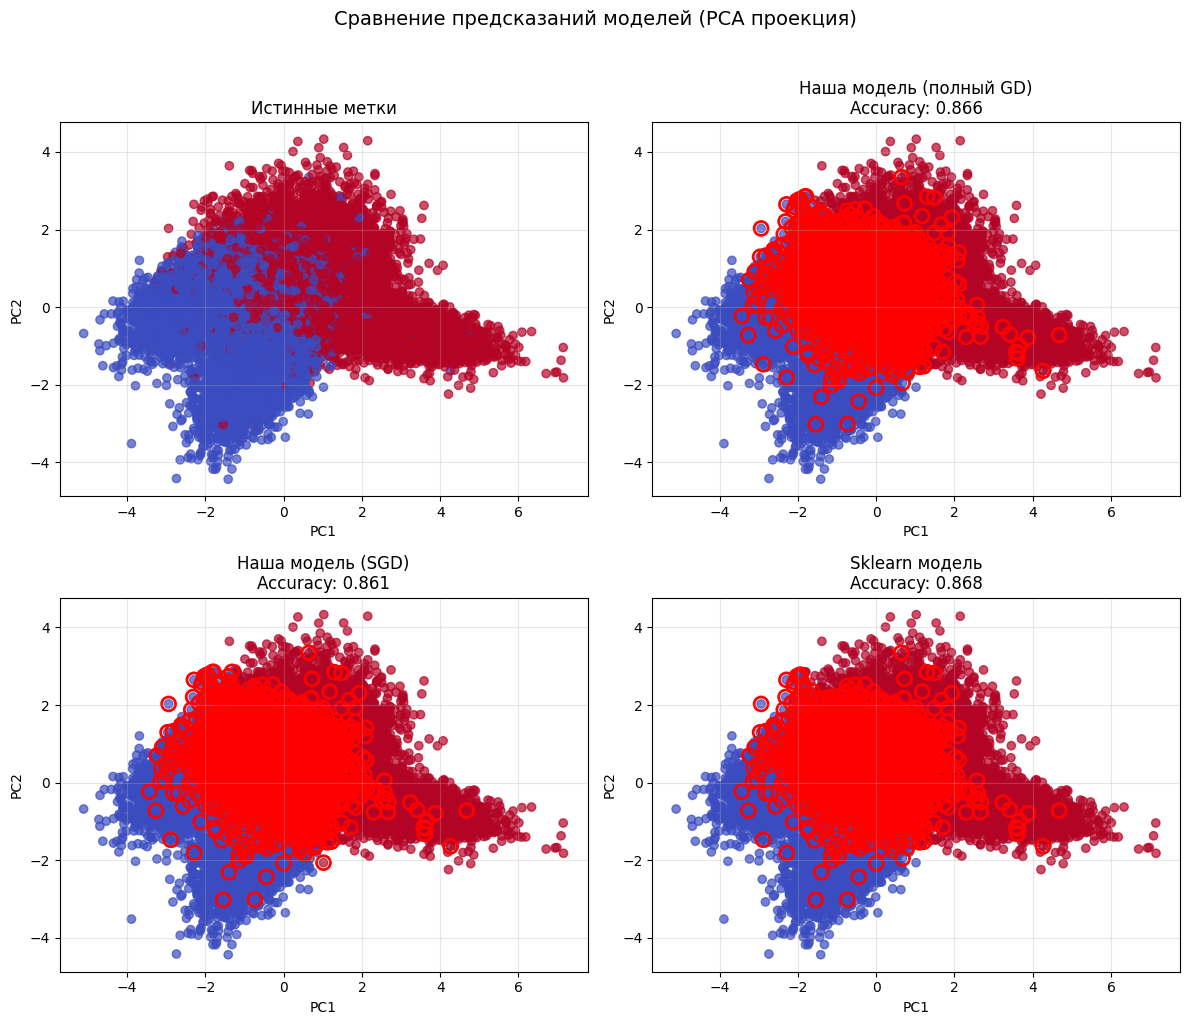

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
print(f"Суммарная: {sum(pca.explained_variance_ratio_):.2f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.7)
axes[0, 0].set_title('Истинные метки')
axes[0, 0].grid(True, alpha=0.3)


y_pred_full = lr_full.predict(X_test)
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_full, cmap='coolwarm', alpha=0.7)

errors = y_pred_full != y_test
axes[0, 1].scatter(X_pca[errors, 0], X_pca[errors, 1],
                   facecolors='none', edgecolors='red', s=100, linewidth=2)
axes[0, 1].set_title(f'Наша модель (полный GD)\nAccuracy: {acc_full:.3f}')
axes[0, 1].grid(True, alpha=0.3)

y_pred_sgd = lr_sgd.predict(X_test)
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_sgd, cmap='coolwarm', alpha=0.7)
errors = y_pred_sgd != y_test
axes[1, 0].scatter(X_pca[errors, 0], X_pca[errors, 1],
                   facecolors='none', edgecolors='red', s=100, linewidth=2)
axes[1, 0].set_title(f'Наша модель (SGD)\nAccuracy: {acc_sgd:.3f}')
axes[1, 0].grid(True, alpha=0.3)


y_pred_sklearn = sklearn_model.predict(X_test)
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_sklearn, cmap='coolwarm', alpha=0.7)
errors = y_pred_sklearn != y_test
axes[1, 1].scatter(X_pca[errors, 0], X_pca[errors, 1],
                   facecolors='none', edgecolors='red', s=100, linewidth=2)
axes[1, 1].set_title(f'Sklearn модель\nAccuracy: {acc_sklearn:.3f}')
axes[1, 1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

plt.suptitle('Сравнение предсказаний моделей (PCA проекция)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

#### Выводы

Модели чаще всёго ошибаются на стыке классов посередине, в то время как по краям все очевидно, если там нет каких-то брошеных точек

Модели работают почти одинаково, sklearn модель чуть лучше

# **Часть 2. Обучение моделей на текстовых данных. (5 баллов)**

 ### **Подготовка данных из реального мира.**

Ещё одна прелесть простых моделей — возможность решать с ними неструктурированные (изначально не табличные) задачи. Давайте посмотрим на это в действии на примере текстов.


Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [64]:
from sklearn.model_selection import train_test_split

PATH = 'train.csv'
df = pd.read_csv(PATH)

df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (1.5 балла).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой (0.2 балла).

In [65]:
import pandas as pd

print("Пропуски в данных:")
print(df.isnull().sum())

df.fillna('', inplace=True)

print("\nПосле заполнения:")
print(df.isnull().sum())

Пропуски в данных:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

После заполнения:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64


- Проанализируйте количество уникальных значений в столбцах, опустив `text`. Сделайте выводы. (0.5 балла)

In [66]:
columns_to_analyze = ['id', 'keyword', 'location', 'target']

for column in columns_to_analyze:
    unique_count = df[column].nunique()
    print(f"{column}: {unique_count} уникальных значений")

id: 7613 уникальных значений
keyword: 222 уникальных значений
location: 3342 уникальных значений
target: 2 уникальных значений


- Проанализируйте соотношение классов в целевой переменной. Какое оно? Выберите метрику, с помощью которой будете оценивать модель.  (0.5 балла)

Распределение классов:
target
0    4342
1    3271
Name: count, dtype: int64

Доля класса 1: 42.97%
Доля класса 0: 57.03%



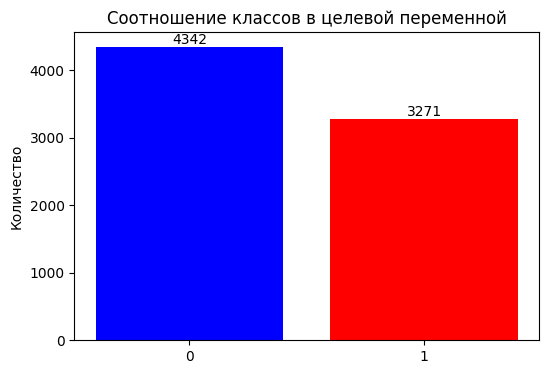

In [72]:
class_counts = df['target'].value_counts()
print("Распределение классов:")
print(class_counts)
print(f"\nДоля класса 1: {class_counts[1]/len(df):.2%}")
print(f"Доля класса 0: {class_counts[0]/len(df):.2%}\n")

plt.figure(figsize=(6,4))
plt.bar(['0', '1'], class_counts.values, color=['blue', 'red'])
plt.title('Соотношение классов в целевой переменной')
plt.ylabel('Количество')

for i, count in enumerate(class_counts.values):
    plt.text(i, count+50, str(count), ha='center')

plt.show()

- Объедините все три текстовых столбца в один для baseline (вам поможет конкатенация строк) (0.3 балла)

In [75]:
df['combined_text'] = df['keyword'] + ' ' + df['location'] + ' ' + df['text']

print("Пример объединенного текста:")
df['combined_text'].iloc[0]

Пример объединенного текста:


'  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

- Наконец, поделите данные на тренировочную и тестовую выборки. (0.2 балла)

In [76]:
X = df['combined_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества и насколько разнообразны данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица? (0.3 балла)

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(df['combined_text'])

print(f"Размер матрицы CountVectorizer: {X_count.shape}")
print(f"Количество строк: {X_count.shape[0]}")
print(f"Количество столбцов (уникальных слов/токенов): {X_count.shape[1]}")

Размер матрицы CountVectorizer: (7613, 23489)
Количество строк: 7613
Количество столбцов (уникальных слов/токенов): 23489


- Обучите логистическую регрессию на полученном наборе. Модель возьмите из библиотеки. Какое качество по выбранной вами метрике у модели получилось на тестовых данных? (0.3 балла)

In [83]:
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X_count, df['target'], test_size=0.2, random_state=42
)

start_time = time.time()

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

lg_train_time = time.time() - start_time

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Результаты модели на CountVectorizer (сырые данные):")
print(f"Время обучения: {lg_train_time:.2f} секунд")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Результаты модели на CountVectorizer (сырые данные):
Время обучения: 1.67 секунд
Accuracy:  0.7991
F1-score:  0.7560
ROC-AUC:   0.7902


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.(0.4 балла)

In [84]:
from sklearn.svm import SVC
import time

start_time = time.time()

svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)

svc_train_time = time.time() - start_time

y_pred_svc = svc_model.predict(X_test)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)
roc_auc_svc = roc_auc_score(y_test, y_pred_svc)

print("РЕЗУЛЬТАТЫ SVC")
print(f"Время обучения: {svc_train_time:.2f} секунд")
print(f"Accuracy:       {accuracy_svc:.4f}")
print(f"F1-score:       {f1_svc:.4f}")
print(f"ROC-AUC:        {roc_auc_svc:.4f}")

РЕЗУЛЬТАТЫ SVC
Время обучения: 13.96 секунд
Accuracy:       0.8070
F1-score:       0.7529
ROC-AUC:        0.7919


#### Выводы

SVC обучается кратно дольше, однако мы наблюдаем почти минимальный прирост метрик, поэтому тут не имеет смысла использовать SVC

### **Задание 12. Улучшение базовых моделей за счет данных. (0.3 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют.

Обучайте и логистическую регрессию, и SVC.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

vectorizer = CountVectorizer(
    max_features=1500,
    min_df=2,
    max_df=0.9,
    stop_words='english',
    ngram_range=(1, 1)
)

X = vectorizer.fit_transform(df['combined_text'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
svc = SVC(random_state=42).fit(X_train, y_train)

print(f"LogisticRegression: {f1_score(y_test, lr.predict(X_test)):.4f} Delta: {f1_score(y_test, lr.predict(X_test)) - f1}")
print(f"SVC: {f1_score(y_test, svc.predict(X_test)):.4f} Delta: {f1_score(y_test, svc.predict(X_test)) - f1_svc}")

LogisticRegression: 0.7210 Delta: -0.03495767978918296
SVC: 0.7385 Delta: -0.014454334365325061


#### Выводы

**Влияние гиперпараметров:**
- max_features=1500 — основной параметр сокращения: оставляет только 1500 самых частых слов
- min_df=2 — убирает редкие слова, встречающиеся менее 2 раз
- max_df=0.9 — убирает слишком частые слова, встречающиеся в >90%
- stop_words='english' — удаляет 300+ стандартных английских стоп-слов (the, and, is и т.д.)
- ngram_range=(1, 1) — использует только отдельные слова, а не словосочетания (экономит признаки)

### **Задание 13. Улучшение базовых моделей за счет данных 2. (0.7 балла).**

В первом пункте мы склеили все строки в одну. Но можно было бы поступить иначе — и получить категории из `'keyword', 'location'`. Протестируйте такой подход на обеих моделях и замерьте качество. Улучшает ли это результат?

In [105]:
from scipy.sparse import hstack

top_locations = df['location'].value_counts().head(20).index
df['location_processed'] = df['location'].apply(
    lambda x: x if x in top_locations and x != '' else 'other'
)

df['keyword_processed'] = df['keyword'].apply(lambda x: x if x != '' else 'unknown')

text_vectorizer = CountVectorizer(
    max_features=1500,
    min_df=2,
    max_df=0.9,
    stop_words='english',
    ngram_range=(1, 1)
)
X_text = text_vectorizer.fit_transform(df['text'])

categorical_cols = ['keyword_processed', 'location_processed']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = encoder.fit_transform(df[categorical_cols])

X_combined = hstack([X_text, X_cat])

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df['target'], test_size=0.2, random_state=42
)

print("\nКАЧЕСТВО")

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_acc = accuracy_score(y_test, lr.predict(X_test))
print(f"LogisticRegression: {lr_acc:.4f}")

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
svc_acc = accuracy_score(y_test, svc.predict(X_test))
print(f"SVC: {svc_acc:.4f}")

print("\nСРАВНЕНИЕ")
print(f"LogisticRegression: было {f1} → стало {lr_acc:.4f} (изменение: {lr_acc-f1:+.4f})")
print(f"SVC: было {f1_svc} → стало {svc_acc:.4f} (изменение: {svc_acc-f1_svc:+.4f})")


КАЧЕСТВО
LogisticRegression: 0.7827
SVC: 0.8017

СРАВНЕНИЕ
LogisticRegression: было 0.7559808612440191 → стало 0.7827 (изменение: +0.0267)
SVC: было 0.7529411764705882 → стало 0.8017 (изменение: +0.0488)


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 1500, 2000]
}

lr = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    lr, param_grid, cv=3, scoring='f1',
    n_jobs=-1, verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search.best_score_:.4f}")

y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred)

print("\nРезультаты")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"F1-score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

print(f"Baseline F1-score:  {f1}")
print(f"После подбора:      {test_f1:.4f}")

Начинаем подбор гиперпараметров...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Лучшие параметры: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Лучший F1-score на кросс-валидации: 0.7443

Результаты
Accuracy:  0.7761
F1-score:  0.7359
ROC-AUC:   0.7704
Baseline F1-score:  0.7559808612440191
После подбора:      0.7359


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Что-то после все возможных попыток гридсерча я не смог побить то, что получил выше :D

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

param_grid = {
    'C': [0.1, 1, 2],
    'kernel': ['linear', 'rbf'],
    'degree': [2, 4],
    'class_weight': [None, 'balanced']
}
svc = SVC(random_state=42, probability=True)

grid_search_svc = GridSearchCV(
    svc, param_grid, cv=2, scoring='f1',
    n_jobs=-1, verbose=1
)

print("Начинаем подбор гиперпараметров для SVC...")
grid_search_svc.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search_svc.best_params_}")
print(f"Лучший F1-score на кросс-валидации: {grid_search_svc.best_score_:.4f}")

y_pred_svc = grid_search_svc.predict(X_test)
test_accuracy_svc = accuracy_score(y_test, y_pred_svc)
test_f1_svc = f1_score(y_test, y_pred_svc)
test_roc_auc_svc = roc_auc_score(y_test, y_pred_svc)

print("\nРезультаты на тестовой выборке")
print(f"Accuracy:  {test_accuracy_svc:.4f}")
print(f"F1-score:  {test_f1_svc:.4f}")
print(f"ROC-AUC:   {test_roc_auc_svc:.4f}")

print("\nСравнение результатов")
print(f"SVC baseline Accuracy:   {f1_svc}")
print(f"SVC после подбора:       {test_f1_svc:.4f} (изменение: {test_accuracy_svc-{f1_svc}:+.4f})")

Начинаем подбор гиперпараметров для SVC...
Fitting 2 folds for each of 24 candidates, totalling 48 fits


Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два [пайплайна](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
# Ваш код здесь

**Опишите общие мысли о работе. Это место для вашей рефлексии, не обязательное, но полезное.**  🐤